In [52]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm #A tqdm progress bar shows you how much time has elapsed and the estimated time remaining for the iterable
import sklearn.metrics as skmetrics #For evaluation metrics

import warnings                               
warnings.filterwarnings('ignore')

# 1(a) 
Split the data into history=before 2015-11-30 (included), and the rest as a test. We will first focus on using history to select and train a model:

In [53]:
df = pd.read_csv('beer.csv')
df.head(3)

,Unnamed: 0,Date,Tempurature_Median,Weekend,Beer_Consumption
0,0,2015-01-01,27.30,0,25.461
1,1,2015-01-02,27.02,0,28.972
2,2,2015-01-03,24.82,1,30.814


In [54]:
df.shape

(365, 5)

In [55]:
test = df[df.Date > '2015-11-30']
history = df[df.Date <= '2015-11-30']

In [56]:
history.shape, test.shape

((334, 5), (31, 5))

# (b) 
Use the plots of the original beer consumption in history, combined with ADF test if you wish, to determine if there’s trend and/or seasonality in the data.

In [57]:
y = df.Beer_Consumption
y_train = history.Beer_Consumption
y_test = test.Beer_Consumption

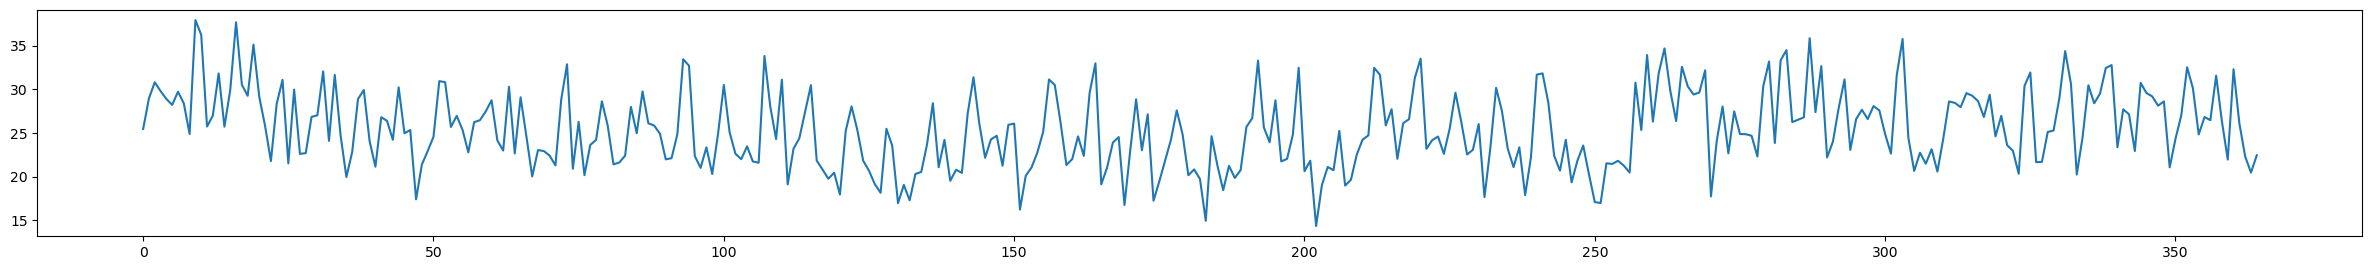

In [58]:
#visualize the data
plt.figure(figsize=(30, 10))
plt.subplot(3,1,1)

plt.plot(y)
plt.show()

In [59]:
result = adfuller(y)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Is stationary? {"Yes" if result[1] < 0.05 else "No"}')

ADF Statistic: -3.4658840974604277
p-value: 0.008907728874036876
Is stationary? Yes


It seems as though there is no trend with seasonality. We can explore seasonality further in part c.

# (c) 
Use a combination of plots, differencing, and/or ADF test to give a range of d, D and a number for seasonal freq m for your grid search.

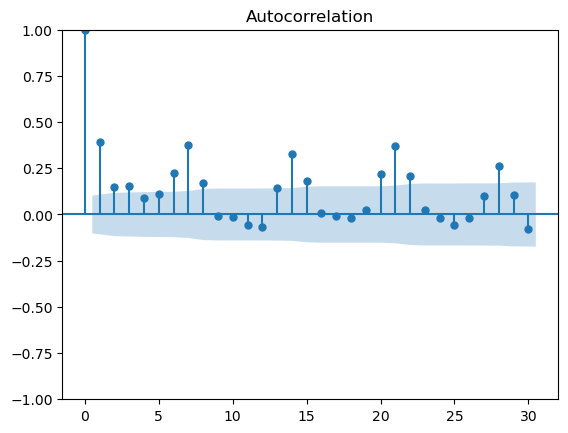

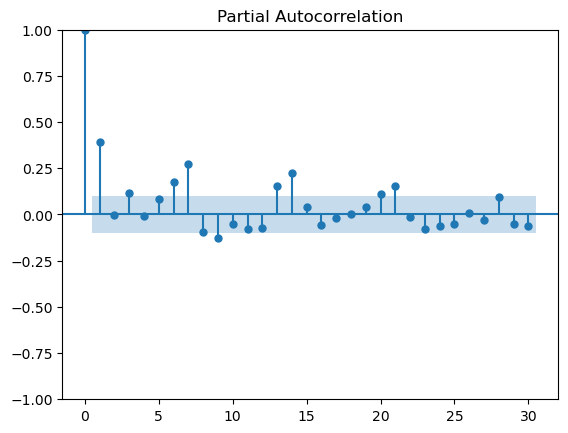

In [60]:
plot_acf(y,lags=30)
plt.show()

plot_pacf(y,lags=30)
plt.show()

Looks like there is seasonality

Based on this data and the ADF test:
- d = 0 because there is no trend and therefore no differencing is necessary
- D = 1 because there is seasonality 
- m = 7 because the peaks on my ACF plot occur every 7 days

We can also experiment with:
- d = 1 as there is some up and down slope within the TS data
- D = 0 the seasonality might not be very strong, especially since there may be some holidays or other events that may affect drinking
- Log transformation, the magnitude of the seasonality seems relatively even but this may further increase similarity of magnitudes

# (d)
Based on your forecasting goal: reach a good average performance on predicting the length of the test set, design a 5-fold cross-validation method with MAE using the historical data. Write Python functions based on this design, and select a model from SARIMA((p,d,q)*(P,D,Q,m)). Report the model selected and validation avg-MAE.

In [61]:
test_size = len(test)

In [62]:
from statsmodels.tsa.arima_process import ArmaProcess
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

def evaluate_models_cv(dataset, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    tscv = TimeSeriesSplit(n_splits=5, test_size=test_size)
    result = []
    best_mae, best_cfg = float("inf"), None
    dataset_values = dataset.values  # Convert Pandas DataFrame to numpy array
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            cfg = [(p, d, q), (P, D, Q, m)]
                            mae = 0
                            
                            for train_idx, test_idx in tscv.split(dataset_values):
                                train, test = dataset_values[train_idx], dataset_values[test_idx]
                                
                                model = ARIMA(train, order=trend_order, seasonal_order=seasonal_order)
                                model_fit = model.fit()
                                
                                predictions = model_fit.get_forecast(steps=len(test))
                                predicted_mean = predictions.predicted_mean
                                
                                mae += mean_absolute_error(test, predicted_mean)
                            
                            mae_avg = mae / 5  # 5-fold cross-validation
                            result.append((cfg, mae_avg))
                            
                            if mae_avg < best_mae:
                                best_mae, best_cfg = mae_avg, cfg
                            print(f'SARIMA{cfg} MAE={mae_avg:.3f}')

    print(f'Best SARIMA{best_cfg} MAE={best_mae:.3f}')

# evaluate_models_cv(y_train, [0, 1, 2, 3], [0], [0, 1, 2, 3], [0, 1, 2, 3], [1], [0, 1, 2, 3], 7)
# evaluate_models_cv(y_train, [0], [0], [1, 2, 3], [1, 2, 3], [0], [1, 2, 3], 7)

After experimenting with different d and D values and with log transformation:

Best model found was (0, 0, 3), (2, 0, 3, 7)

# (e)
fit the model of chosen orders with all the data from history, then generate the forecast for the test data. Draw the plot with "history", "test" and "test forecast" together and
report the MAE for the test forecast.

In [63]:
model = ARIMA(y_train, order=(0, 0, 3), seasonal_order=(2, 0, 3, 7))
model_fit = model.fit()

In [64]:
forecast = model_fit.forecast(steps=test_size)

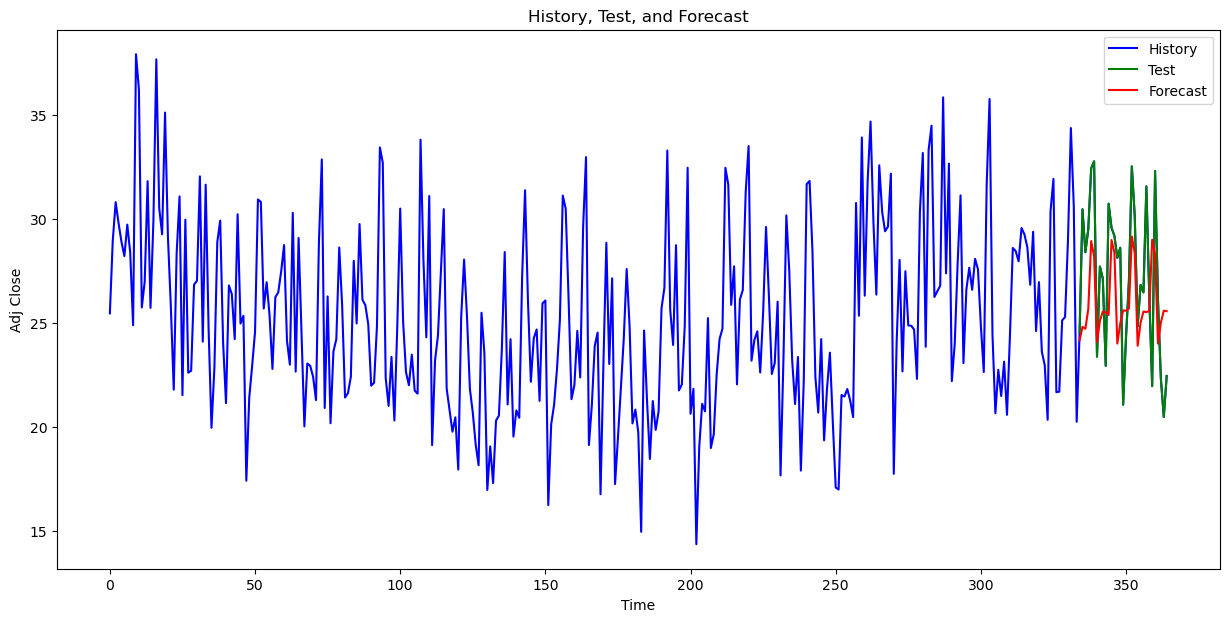

In [65]:
plt.figure(figsize=(15, 7))

# Plot history
plt.plot(y, label='History', color='blue')

# Plot test data
plt.plot(range(len(history), len(history) + test_size), y_test, label='Test', color='green')

# Plot forecast
plt.plot(range(len(history), len(history) + test_size), forecast, label='Forecast', color='red')

plt.title('History, Test, and Forecast')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.legend()

In [66]:
mean_absolute_error(y_test, forecast)

2.918487076834452

# 2. 
In this question, you will acquainted with fitting data with SARIMAX. Use the same train and test from the above question, and consider the column "median temperature" as an exogenous predictor for beer consumption. Use the train set however you like to select and fit a SARIMAX model to forecast beer consumption of the test period. Report the selected model and the test MAE.

In [67]:
X_train = history['Tempurature_Median']
X_test = test['Tempurature_Median']

In [68]:
def evaluate_models_cv_sarimax(dataset, exog, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    tscv = TimeSeriesSplit(n_splits=5, test_size=test_size)
    result = []
    best_mae, best_cfg = float("inf"), None
    dataset_values = dataset.values  # Convert Pandas DataFrame to numpy array
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            cfg = [(p, d, q), (P, D, Q, m)]
                            mae = 0
                            
                            for train_idx, test_idx in tscv.split(dataset_values):
                                train, test = dataset_values[train_idx], dataset_values[test_idx]
                                exog_train, exog_test = exog[train_idx], exog[test_idx]
                                
                                model = ARIMA(endog=train, exog=exog_train, order=trend_order, seasonal_order=seasonal_order)
                                model_fit = model.fit()
                                
                                predictions = model_fit.get_forecast(steps=len(test), exog=exog_test)
                                predicted_mean = predictions.predicted_mean
                                
                                mae += mean_absolute_error(test, predicted_mean)
                            
                            mae_avg = mae / 5  # 5-fold cross-validation
                            result.append((cfg, mae_avg))
                            
                            if mae_avg < best_mae:
                                best_mae, best_cfg = mae_avg, cfg
                            print(f'SARIMAX{cfg} MAE={mae_avg:.3f}')

    print(f'Best SARIMAX{best_cfg} MAE={best_mae:.3f}')

# evaluate_models_cv_sarimax(y_train, X_train, [0, 1, 2, 3], [0], [0, 1, 2, 3], [0, 1, 2, 3], [1], [0, 1, 2, 3], 7)
# evaluate_models_cv_sarimax(y_train, X_train, [0], [0], [3], [1, 2, 3], [0, 1], [1, 2, 3], 7)


Once again best model is (0, 0, 3), (2, 0, 3, 7)

In [69]:
model = ARIMA(endog=y_train, exog=X_train, order=(0, 0, 3), seasonal_order=(2, 0, 3, 7))
model_fit = model.fit()
forecast = model_fit.forecast(steps=test_size, exog=X_test)

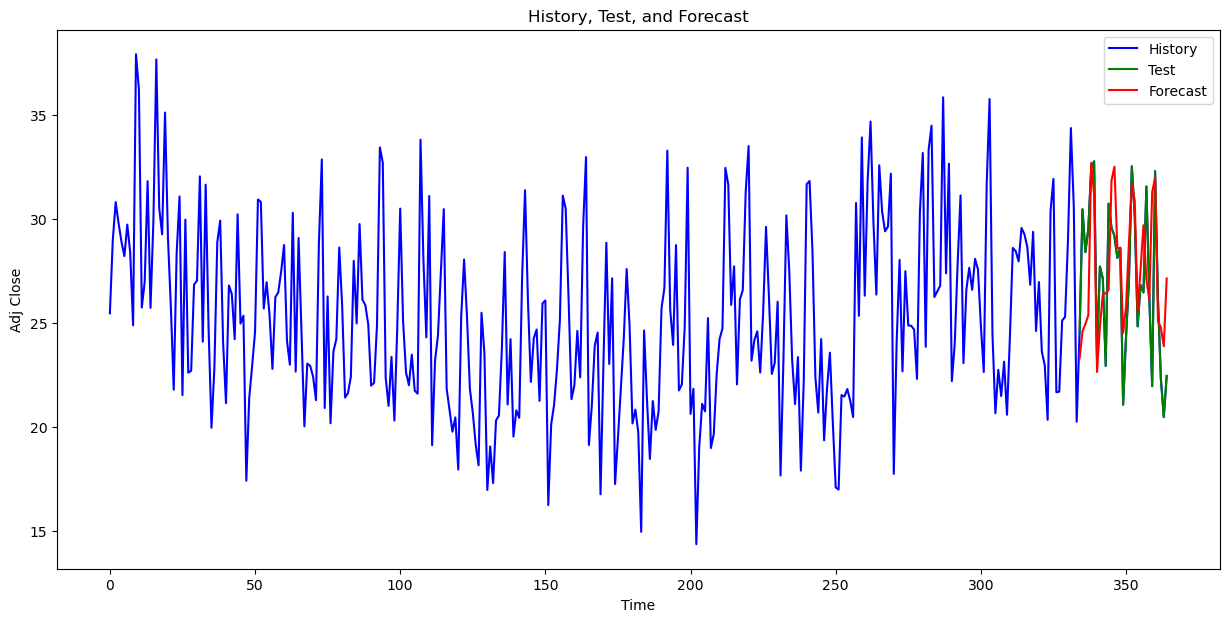

In [70]:
plt.figure(figsize=(15, 7))

# Plot history
plt.plot(y, label='History', color='blue')

# Plot test data
plt.plot(range(len(history), len(history) + test_size), y_test, label='Test', color='green')

# Plot forecast
plt.plot(range(len(history), len(history) + test_size), forecast, label='Forecast', color='red')

plt.title('History, Test, and Forecast')
plt.xlabel('Time')
plt.ylabel('Adj Close')
plt.legend()

In [71]:
mean_absolute_error(y_test, forecast)

2.375413819604302

Looks like our MAE improved using SARIMAX

# 3(a). 
In this question, you will acquainted with fitting data with VAR. In L5, we have use the "microdata" from statsmodels to practice SARIMAX. In this questions, consider "realgdp" and "realcons" as a vector time series and fit a VAR model: 

Aggregate the data into quarterly data the same way as how I did it in L5. Split the data into the train (on or before the end of 2007) and the test (the rest data). Nothing to be submitted for this part.

In [72]:
macrodata = sm.datasets.macrodata.load_pandas().data
df=macrodata[["year","quarter","realgdp","realcons"]]

In [73]:
dates = df[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)

df=df[["realgdp","realcons"]]
df.index = pd.DatetimeIndex(quarterly)

df.head(3)

,realgdp,realcons
1959-03-31,2710.349,1707.4
1959-06-30,2778.801,1733.7
1959-09-30,2775.488,1751.8


In [74]:
test = df[df.index > '2008-1-1']
train = df[df.index < '2008-1-1']
train.shape, test.shape

((196, 2), (7, 2))

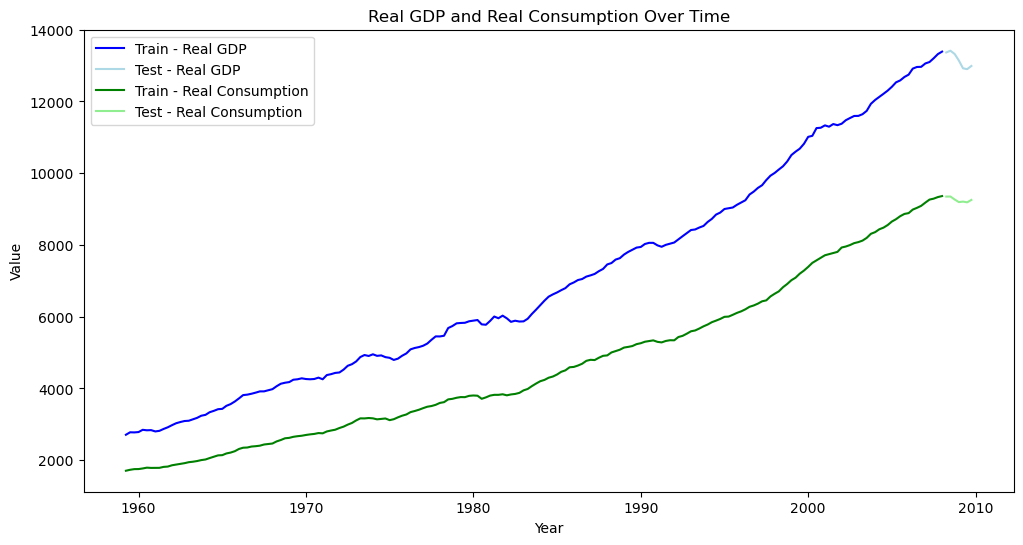

In [75]:
plt.figure(figsize=(12, 6))
plt.plot(train['realgdp'], label='Train - Real GDP', color='blue')
plt.plot(test['realgdp'], label='Test - Real GDP', color='lightblue')
plt.plot(train['realcons'], label='Train - Real Consumption', color='green')
plt.plot(test['realcons'], label='Test - Real Consumption', color='lightgreen')
plt.title('Real GDP and Real Consumption Over Time')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()


# (b) 
Use the train data however you want to select and fit a VAR model and forecast the len(test). The key here is you need to difference the data manually to reach stationary, fit VAR on the stationary data, then reverse-difference to give the forecast of the original scale. The model should provide forecast for both "realgdp" and "realcons". Draw a plot with "train_realgdp", "train_realcons", "test_realgdp", "test_realcons", "test_realgdp_pred", "test_realcons_pred". Attach this plot as the answer of this question.


<Axes: >

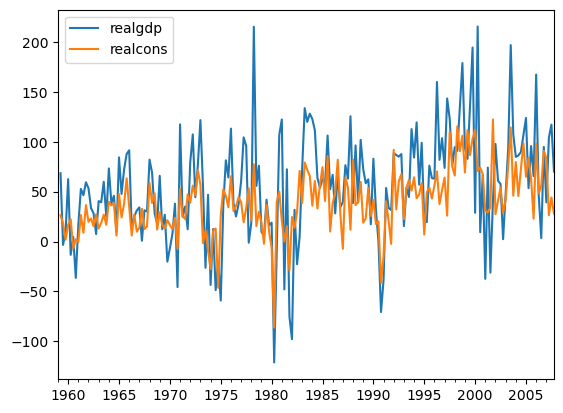

In [76]:
d1 = train.diff() 
d1.plot()

This doesn't look quite stationary, there may be a slight trend

<Axes: >

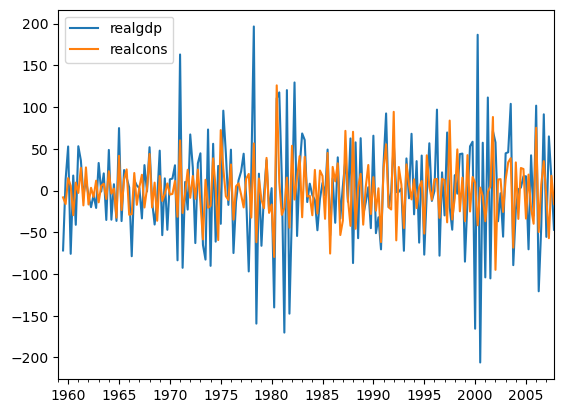

In [77]:
d2 = d1.diff() 
d2.plot()

In [78]:
d2 = d2.dropna()
result = adfuller(d2['realgdp'])
print('Results for realgdp:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Is stationary? {"Yes" if result[1] < 0.05 else "No"}')

Results for realgdp:
ADF Statistic: -5.972492601364316
p-value: 1.9214901886193175e-07
Is stationary? Yes


In [79]:
result = adfuller(d2['realcons'])
print('Results for realcons:')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Is stationary? {"Yes" if result[1] < 0.05 else "No"}')

Results for realcons:
ADF Statistic: -17.8569826080855
p-value: 3.0637990560194413e-30
Is stationary? Yes


In [80]:
from statsmodels.tsa.api import VAR

test_size = len(test)

def train_test_eval(df, p, test_size):
    best_rmse, best_order = float("inf"), None
    train = df[:-test_size]
    test = df[-test_size:]
    for i in p:
        model = VAR(train)
        results = model.fit(i)
        predictions=results.forecast(y=train.values[-i:],steps=test_size)
        pred=pd.DataFrame(predictions)
        rmse = (np.sqrt(skmetrics.mean_squared_error(test[test.columns[0]], pred[pred.columns[0]]))+np.sqrt(skmetrics.mean_squared_error(test[test.columns[1]], pred[pred.columns[1]])))/2
        if rmse< best_rmse:
            best_rmse, best_order = rmse, i
        print('VAR%s RMSE=%.3f' % (i,rmse))
    print('Best VAR%s RMSE=%.3f' % (best_order, best_rmse))
    
train_test_eval(d2, p=[1,2,3,4,5,6,7], test_size=test_size)

VAR1 RMSE=45.326
VAR2 RMSE=48.711
VAR3 RMSE=47.608
VAR4 RMSE=49.162
VAR5 RMSE=50.195
VAR6 RMSE=47.843
VAR7 RMSE=48.536
Best VAR1 RMSE=45.326


In [81]:
best_p = 4

model = VAR(d2)
results = model.fit(best_p)

In [82]:
predictions = results.forecast(y=d2.values[-best_p:], steps=test_size)
df_forecast = pd.DataFrame(predictions, index=test.index, columns=d2.columns)
df_forecast

,realgdp,realcons
2008-03-31,-28.546529,4.279804
2008-06-30,15.231473,-0.881603
2008-09-30,23.019934,3.378126
2008-12-31,-7.895621,3.705003
2009-03-31,-1.873466,-3.678608
2009-06-30,-4.134156,-2.020296
2009-09-30,4.151278,2.406558


In [83]:
# Creating a DataFrame for the forecasts on the original scale
forecast = pd.DataFrame(index=test.index)

for col in train.columns:
    # Reverse-differencing the forecasts once to the first order
    first_order_diff = (train[col].iloc[-1] - train[col].iloc[-2]) + df_forecast[col].cumsum()
    # Reverse-differencing the forecasts again to the original scale
    forecast[col + '1D'] = df_forecast[col]
    forecast[col + 'Forecast'] = train[col].iloc[-1] + df_forecast[col].cumsum()

print(forecast)

            realgdp1D  realgdpForecast  realcons1D  realconsForecast
2008-03-31 -28.546529     13362.702471    4.279804       9367.879804
2008-06-30  15.231473     13377.933944   -0.881603       9366.998201
2008-09-30  23.019934     13400.953878    3.378126       9370.376327
2008-12-31  -7.895621     13393.058257    3.705003       9374.081330
2009-03-31  -1.873466     13391.184791   -3.678608       9370.402721
2009-06-30  -4.134156     13387.050636   -2.020296       9368.382426
2009-09-30   4.151278     13391.201914    2.406558       9370.788984


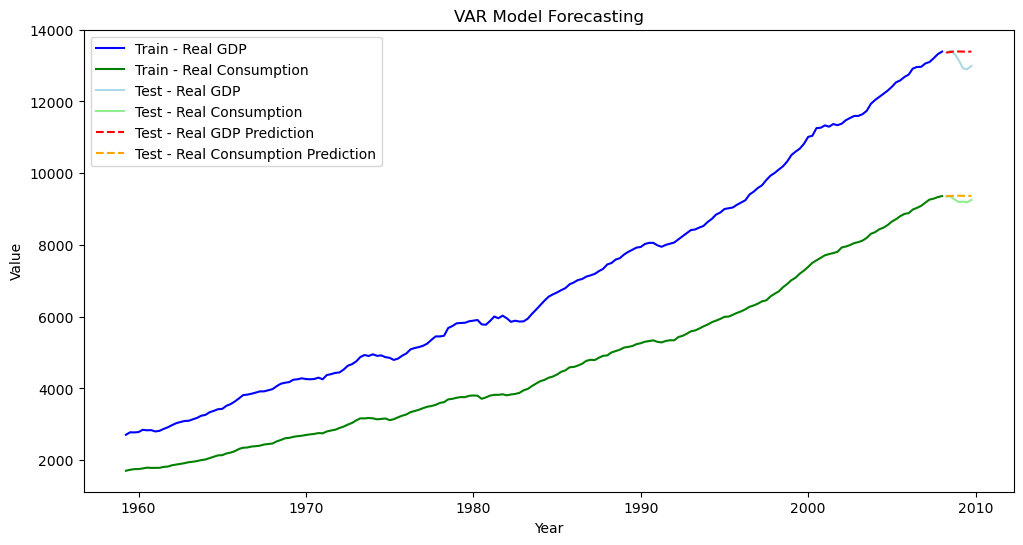

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(train['realgdp'], label='Train - Real GDP', color='blue')
plt.plot(train['realcons'], label='Train - Real Consumption', color='green')
plt.plot(test['realgdp'], label='Test - Real GDP', color='lightblue')
plt.plot(test['realcons'], label='Test - Real Consumption', color='lightgreen')
plt.plot(test.index, forecast['realgdpForecast'], label='Test - Real GDP Prediction', color='red', linestyle='dashed')
plt.plot(test.index, forecast['realconsForecast'], label='Test - Real Consumption Prediction', color='orange', linestyle='dashed')
plt.title('VAR Model Forecasting')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()